# Linear Regression Model

**This note book do an apply the linear regression model on the data**

In [2]:
# import packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

In [3]:
# Read in data 
df_pickup_JFK = pd.read_csv('../data/curated/JFK_pickup_data.csv')
df_pickup_JFK.head()

,trip_duration,weekend,weekday,[0-1],[1-2],[2-3],[3-4],[4-5],[5-6],[6-7],...,[20-21],[21-22],[22-23],morning_rush,evening_rush,trip_distance,total_surcharge,fare_amount,tip_amount,tip_ratio
0,29.283333,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,18.20,6.92,52.0,0.00,0.000000
1,22.616667,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,9.93,1.30,30.0,6.26,16.666667
2,10.650000,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,4.30,1.30,14.5,3.95,20.000000
3,30.350000,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,18.39,1.30,50.5,10.36,16.666667
4,30.750000,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,23.47,1.30,61.5,12.56,16.666667


**From the pairwise plot in exploratory_analysis.ipynb**

* trip_duration vs. tip_amount: There's a somewhat linear relationship between these variables, although with a lot of variance. It doesn't seem to need any immediate transformation.

* trip_distance vs. tip_amount: This relationship also appears roughly linear, with some increase in variance for longer trips.

* total_surcharge vs. tip_amount: There's a concentration of data points at certain surcharge values, but no clear linear relationship.

* fare_amount vs. tip_amount: This has a fairly linear relationship with a spread of data points.

* trip_distance: This variable seems to be right-skewed, which is a potential candidate for transformations like logarithmic or square root transformation to make it more normally distributed.

* fare_amount: Shows a similar skewness pattern as trip_distance.

* --> Consider transformation of variables

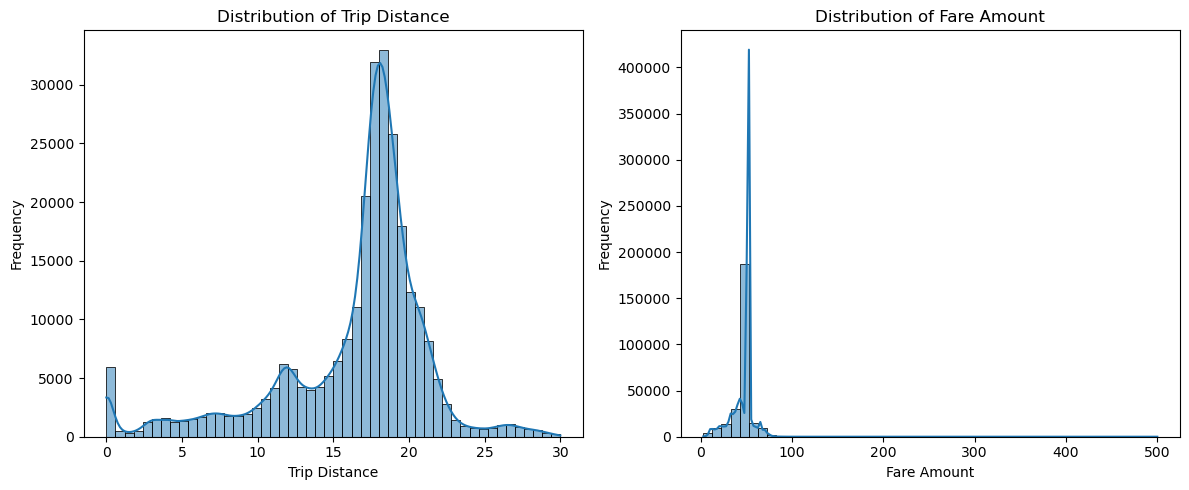

In [4]:
# Plot the histograms for trip_distance and fare_amount to examine their distributions in more detail.

# Plotting histograms for trip_distance and fare_amount
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df_pickup_JFK['trip_distance'], bins=50, kde=True, ax=ax[0])
ax[0].set_title('Distribution of Trip Distance')
ax[0].set_xlabel('Trip Distance')
ax[0].set_ylabel('Frequency')

sns.histplot(df_pickup_JFK['fare_amount'], bins=50, kde=True, ax=ax[1])
ax[1].set_title('Distribution of Fare Amount')
ax[1].set_xlabel('Fare Amount')
ax[1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('../plots/trip_distance_and_fare_amount_distribution.png')
plt.show()


* Trip Distance: The distribution of trip_distance is right-skewed. This means that most trips are short, but there are a few longer trips. A transformation, such as a logarithmic transformation, might help make this distribution more symmetric or normal-like.

* Fare Amount: The distribution of fare_amount mirrors that of trip_distance and is also right-skewed. It could benefit from a similar transformation.

* Also, from the pairwise plot, there is some sign of heteroskedasticity --> use robuse standard error and transform variables

* Our data has narrow down but still appears to have heteroskedasticity and skewness of the data

* We perform variable transformation by taking log of variable

* To see which variable to transform, we proceed with fitting a testing linear regression model and perform Breusch-Pagan Test

# Test for heteroskedasticity


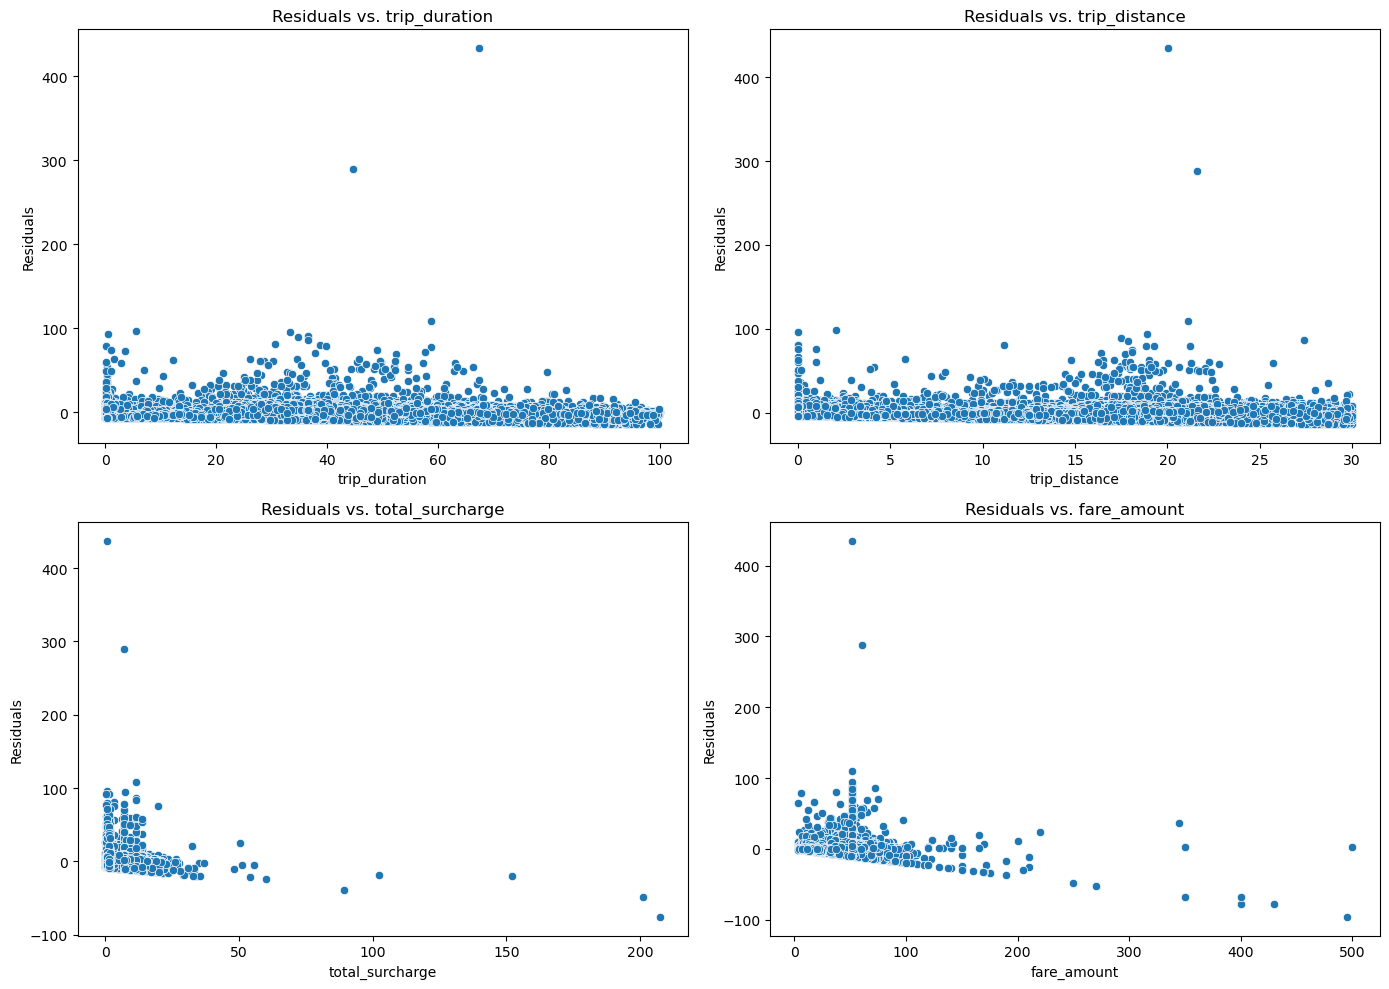

In [5]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model
model = LinearRegression()

# Variables
predictors = ['trip_duration', 'trip_distance', 'total_surcharge', 'fare_amount']
residuals_dict = {}

# For each predictor, fit the model and store residuals
for predictor in predictors:
    X = df_pickup_JFK[[predictor]]
    y = df_pickup_JFK['tip_amount']
    
    # Fit the model
    model.fit(X, y)
    
    # Predict the values
    y_pred = model.predict(X)
    
    # Calculate residuals
    residuals = y - y_pred
    
    # Store residuals
    residuals_dict[predictor] = residuals

# Plotting residuals against the predictors
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

for i, predictor in enumerate(predictors):
    ax = plt.subplot(2, 2, i+1)
    sns.scatterplot(x=df_pickup_JFK[predictor], y=residuals_dict[predictor], ax=ax)
    ax.set_title(f"Residuals vs. {predictor}")
    ax.set_xlabel(predictor)
    ax.set_ylabel("Residuals")

plt.tight_layout()
plt.savefig('../plots/test_for_variables_transformation_linref.png')
plt.show()


In [6]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

bp_test_results = {}

# Performing Breusch-Pagan test for each predictor
for predictor in predictors:
    X = df_pickup_JFK[[predictor]]
    X = sm.add_constant(X)  # Adding a constant (intercept) to the model
    y = df_pickup_JFK['tip_amount']
    
    _, pval, _, _ = het_breuschpagan(residuals_dict[predictor], X)
    bp_test_results[predictor] = pval

bp_test_results


{'trip_duration': 0.7757765822740509,
 'trip_distance': 0.0012271504592616274,
 'total_surcharge': 0.12564052301650608,
 'fare_amount': 1.7837348606317856e-38}

**The Breusch-Pagan test results provide p-values for each predictor variable:**

* trip_duration: p = 0.7757

Not significant, suggesting no heteroskedasticity.

* trip_distance: p = 0.0012

Significant at the 0.05 level, indicating heteroskedasticity.

* total_surcharge: p = 0.1256

Not significant, suggesting no heteroskedasticity.

* fare_amount: p ≈ 0

Highly significant, indicating strong evidence of heteroskedasticity.

**Based on the Breusch-Pagan test:**

* trip_distance and fare_amount exhibit heteroskedasticity.

* trip_duration and total_surcharge do not show significant evidence of heteroskedasticity.

**Hence, take log transformation of trip_distance and fare_amount**

# Fit the Linear Model

In [7]:
# Take log transformation of trip_distance and fare_amount
# For safety, we'll add 1 to ensure we don't take log of zero or negative numbers
df_pickup_JFK['log_trip_distance'] = np.log(df_pickup_JFK['trip_distance'] + 1)
df_pickup_JFK['log_fare_amount'] = np.log(df_pickup_JFK['fare_amount'] + 1)

# Specify predictors and dependent variable
predictor_columns = ['log_trip_distance', 'log_fare_amount', 'weekend', 'weekday', 'morning_rush', 'evening_rush', 'total_surcharge']
time_bins = [col for col in df_pickup_JFK.columns if '[' in col and ']' in col]
predictor_columns.extend(time_bins)
X_timebins = df_pickup_JFK[predictor_columns]
y = df_pickup_JFK['tip_amount']

# Add a constant to the predictor variables (for intercept)
X_timebins_sm = sm.add_constant(X_timebins)

# Fit the model using statsmodels
model_sm = sm.OLS(y, X_timebins_sm).fit()

# Display the summary
model_summary = model_sm.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     3292.
Date:                Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:26:47   Log-Likelihood:            -7.4757e+05
No. Observations:              269641   AIC:                         1.495e+06
Df Residuals:                  269613   BIC:                         1.495e+06
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -9.7045      0.069   -141.260      0.000      -9.839      -9.570
log_trip_distance     0.0477      0.016      2.933      0.003       0.016       0.080
log_fare_amount       5.9724      0.029    207.685      0.000       5.916       6.029
weekend              -4.8371      0.036   -135.123      0.000      -4.907      -4.767
weekday              -4.8674      0.035   -139.458      0.000      -4.936      -4.799
morning_rush         -0.1326      0.031     -4.224      0.000      -0.194      -0.071
evening_rush          0.1164      0.028      4.176      0.000       0.062       0.171
total_surcharge       0.1786      0.002     83.788      0.000       0.174       0.183
[0-1]                 0.0483      0.048      1.008      0.313      -0.046       0.142
[1-2]                -0.1065      0.068     -1.555      0.120      -0.241       0.028
[2-3]                -0.1527      0.123     -1.237      0.216      -0.394       0.089
[3-4]                -0.5851      0.134     -4.365      0.000      -0.848      -0.322
[4-5]                -0.1530      0.113     -1.354      0.176      -0.374       0.068
[5-6]                -0.1502      0.058     -2.570      0.010      -0.265      -0.036
[6-7]                -0.1788      0.054     -3.312      0.001      -0.285      -0.073
[7-8]                 0.0918      0.036      2.564      0.010       0.022       0.162
[8-9]                -0.0196      0.037     -0.528      0.598      -0.092       0.053
[9-10]               -0.2048      0.042     -4.909      0.000      -0.287      -0.123
[10-11]               0.0111      0.057      0.196      0.845      -0.100       0.122
[11-12]               0.1396      0.061      2.280      0.023       0.020       0.260
[12-13]               0.0815      0.053      1.551      0.121      -0.021       0.185
[13-14]               0.0550      0.048      1.135      0.256      -0.040       0.150
[14-15]               0.2194      0.045      4.875      0.000       0.131       0.308
[15-16]               0.2446      0.044      5.544      0.000       0.158       0.331
[16-17]               0.2868      0.043      6.613      0.000       0.202       0.372
[17-18]               0.0872      0.026      3.401      0.001       0.037       0.137
[18-19]               0.0534      0.025      2.127      0.033       0.004       0.103
[19-20]              -0.0241      0.026     -0.933      0.351      -0.075       0.027
[20-21]               0.2488      0.042      5.924      0.000       0.167       0.331
[21-22]               0.0999      0.043      2.333      0.020       0.016       0.184
[22-23]               0.1513      0.043      3.481      0.001       0.066       0.237
==============================================================================
Omnibus:                   394608.373   Durbin-Watson:                   1.995
P

In [8]:
# Extracting the model coefficients
coefficients_sm = model_sm.params

coefficients_sm_df = pd.DataFrame({
    'Predictor': coefficients_sm.index,
    'Coefficient': coefficients_sm.values
})

coefficients_sm_df

,Predictor,Coefficient
0,const,-9.704524
1,log_trip_distance,0.047723
2,log_fare_amount,5.972449
3,weekend,-4.837108
4,weekday,-4.867416
5,morning_rush,-0.132572
6,evening_rush,0.116423
7,total_surcharge,0.178622
8,[0-1],0.048335
9,[1-2],-0.106499


**Stepwise Selection**

In [9]:
import statsmodels.formula.api as smf

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ 
    Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    """
    included = list(initial_list)
    while True:
        changed=False
        # Forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print(f'Adding {best_feature} with p-value {best_pval:.6}')

        # Backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # Use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f'Dropping {worst_feature} with p-value {worst_pval:.6}')
        if not changed:
            break
    return included

# Using the stepwise selection function to get the optimal predictors
optimal_predictors = stepwise_selection(X_timebins, y)

optimal_predictors


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding total_surcharge with p-value 0.0


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding log_fare_amount with p-value 0.0


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding morning_rush with p-value 2.16247e-25


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [6-7] with p-value 9.80993e-13


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [5-6] with p-value 2.81077e-09


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [3-4] with p-value 2.67158e-08


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [16-17] with p-value 6.72827e-07


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [20-21] with p-value 1.71741e-06


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [15-16] with p-value 1.23603e-05


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [9-10] with p-value 3.12477e-05


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [14-15] with p-value 0.000181214


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding evening_rush with p-value 4.01652e-05


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [22-23] with p-value 0.00067008


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding log_trip_distance with p-value 0.00412915


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [1-2] with p-value 0.00910697


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Adding [19-20] with p-value 0.00926779


/var/folders/yy/7q_gmwc10sd3qdpgyfbhm17c0000gn/T/ipykernel_66481/400710341.py:25: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


['total_surcharge',
 'log_fare_amount',
 'morning_rush',
 '[6-7]',
 '[5-6]',
 '[3-4]',
 '[16-17]',
 '[20-21]',
 '[15-16]',
 '[9-10]',
 '[14-15]',
 'evening_rush',
 '[22-23]',
 'log_trip_distance',
 '[1-2]',
 '[19-20]']

In [10]:
# Fit the parsimonious model using the optimal predictors from stepwise
X_parsimonious = df_pickup_JFK[optimal_predictors]
X_parsimonious_sm = sm.add_constant(X_parsimonious)

# Fit the model using statsmodels
parsimonious_model = sm.OLS(y, X_parsimonious_sm).fit()

# Display the summary of the parsimonious model
parsimonious_model_summary = parsimonious_model.summary()
parsimonious_model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             tip_amount   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     5554.
Date:                Mon, 21 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:27:00   Log-Likelihood:            -7.4758e+05
No. Observations:              269641   AIC:                         1.495e+06
Df Residuals:                  269624   BIC:                         1.495e+06
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -14.5234      0.099   -146.899      0.000     -14.717     -14.330
total_surcharge       0.1782      0.002     84.439      0.000       0.174       0.182
log_fare_amount       5.9764      0.029    208.044      0.000       5.920       6.033
morning_rush         -0.1486      0.033     -4.556      0.000      -0.213      -0.085
[6-7]                -0.2345      0.045     -5.207      0.000      -0.323      -0.146
[5-6]                -0.2062      0.050     -4.099      0.000      -0.305      -0.108
[3-4]                -0.6388      0.131     -4.887      0.000      -0.895      -0.383
[16-17]               0.2329      0.031      7.427      0.000       0.171       0.294
[20-21]               0.1948      0.030      6.570      0.000       0.137       0.253
[15-16]               0.1908      0.033      5.870      0.000       0.127       0.254
[9-10]               -0.2437      0.059     -4.142      0.000      -0.359      -0.128
[14-15]               0.1652      0.034      4.900      0.000       0.099       0.231
evening_rush          0.1327      0.025      5.315      0.000       0.084       0.182
[22-23]               0.0972      0.032      3.064      0.002       0.035       0.159
log_trip_distance     0.0481      0.016      2.964      0.003       0.016       0.080
[1-2]                -0.1611      0.062     -2.610      0.009      -0.282      -0.040
[19-20]              -0.0938      0.036     -2.602      0.009      -0.164      -0.023
==============================================================================
Omnibus:                   394625.070   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       6084861133.427
Skew:                           7.568   Prob(JB):                         0.00
Kurtosis:                     738.777   Cond. No.                         133.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Residual Analysis**

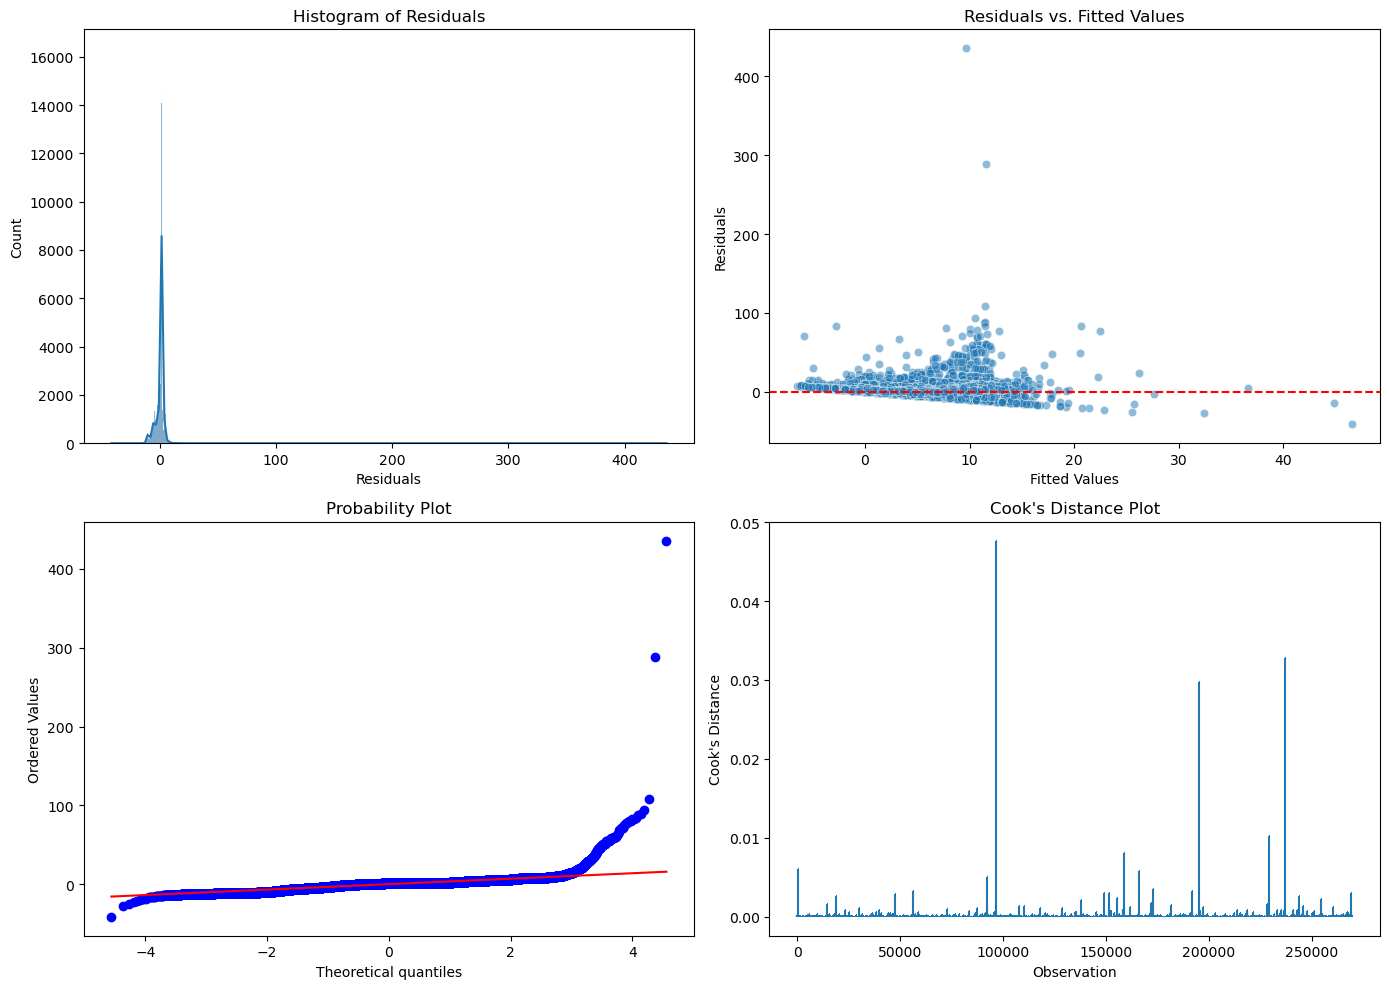

In [11]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# Extract residuals
residuals = model_sm.resid
fitted_values = model_sm.fittedvalues

# Set up a 2x2 grid for the plots
fig, ax = plt.subplots(2, 2, figsize=(14, 10))

# Histogram of residuals
sns.histplot(residuals, kde=True, ax=ax[0, 0])
ax[0, 0].set_title("Histogram of Residuals")
ax[0, 0].set_xlabel("Residuals")

# Residuals vs. Fitted Values Plot
sns.scatterplot(x=fitted_values, y=residuals, ax=ax[0, 1], alpha=0.5)
ax[0, 1].set_title("Residuals vs. Fitted Values")
ax[0, 1].set_xlabel("Fitted Values")
ax[0, 1].set_ylabel("Residuals")
ax[0, 1].axhline(y=0, color='r', linestyle='--')

# QQ-Plot
stats.probplot(residuals, dist="norm", plot=ax[1, 0])

# Cook's Distance Plot
influence = model_sm.get_influence()
(c, p) = influence.cooks_distance
ax[1, 1].stem(np.arange(len(c)), c, markerfmt=",", basefmt=" ")
ax[1, 1].set_title("Cook's Distance Plot")
ax[1, 1].set_xlabel("Observation")
ax[1, 1].set_ylabel("Cook's Distance")

plt.tight_layout()
plt.savefig('../plots/residual_analysis_linreg.png')
plt.show()

**Model Validation**

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

# Splitting the data into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X_timebins, y, test_size=0.2, random_state=42)

# Fit the model on the training dataset
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict on the testing dataset
y_pred = lr.predict(X_test)

# Calculate MAE, MSE, and RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

mae, mse, rmse

(2.591232179407129, 14.54981360396129, 3.81442179156439)

**K-fold cross validation**

In [13]:
from sklearn.model_selection import cross_val_score

# Define a function to calculate RMSE for cross_val_score
def rmse_cross_val(model, X, y):
    return np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))

# Take a random subset of the data for cross-validation (for memory efficiency)
sample_size_cv = 20000  # Taking a sample of 20,000 rows
X_subset_cv = X_timebins.sample(n=sample_size_cv, random_state=42)
y_subset_cv = y[X_subset_cv.index]

# Perform 5-fold cross-validation and calculate RMSE for each fold
cross_val_rmse = rmse_cross_val(lr, X_subset_cv, y_subset_cv)

cross_val_rmse_avg = np.mean(cross_val_rmse)
cross_val_rmse_std = np.std(cross_val_rmse)

cross_val_rmse_avg, cross_val_rmse_std


(3.815905719829005, 0.1373679329453124)